In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
image_folder = '/content/drive/MyDrive/RESEARCH/models/filesFolder/NLMCXR_png'
df_path = '/content/drive/MyDrive/RESEARCH/models/filesFolder/df_final.pkl'
chexnet_weights = '/content/drive/MyDrive/RESEARCH/models/filesFolder/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

Check how many images are there and how many report files are there

In [ ]:

df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) 
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<SOS> ' + df.impression + ' <EOS>'
df['impression_ip'] = '<SOS> ' + df.impression
df['impression_op'] = df.impression + ' <EOS>' 
print(df.shape)
df.head(2)

(4033, 7)


,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,/content/drive/MyDrive/RESEARCH/models/filesFo...,/content/drive/MyDrive/RESEARCH/models/filesFo...,minimal atelectasis left base no acute abnorma...,1317.xml,<SOS> minimal atelectasis left base no acute a...,<SOS> minimal atelectasis left base no acute a...,minimal atelectasis left base no acute abnorma...
1,/content/drive/MyDrive/RESEARCH/models/filesFo...,/content/drive/MyDrive/RESEARCH/models/filesFo...,clear lungs . no acute cardiopulmonary abnorma...,1939.xml,<SOS> clear lungs . no acute cardiopulmonary a...,<SOS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...


In [ ]:
df['impression'].value_counts()

no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                          383
no acute cardiopulmonary findings .                                                                                                                                                                                                                                             172
no acute cardiopulmonary disease .                                                                                                                                                                                                                                              147
no acute cardiopulmonary abnormalities .                                                                                                                                    

Here we can see that some captions have only 1 values in the entire dataset while some datasets are having more than 5. What I will do here is that I will upsample all those datapoint which impression value counts <=5. First I will remove all those datapoints which are duplicated based on xml file name(ie of the same patient because some patients are having more than 2 images) and then split the data into train and test.

In [ ]:
df.drop_duplicates(subset = ['xml file name'], inplace = True)

In [ ]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [ ]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changin column names
del df['impression_x'] #deleting impression_x column
df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,minimal atelectasis left base no acute abnorma...,/content/drive/MyDrive/RESEARCH/models/filesFo...,/content/drive/MyDrive/RESEARCH/models/filesFo...,1317.xml,<SOS> minimal atelectasis left base no acute a...,<SOS> minimal atelectasis left base no acute a...,minimal atelectasis left base no acute abnorma...,1
1,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/RESEARCH/models/filesFo...,/content/drive/MyDrive/RESEARCH/models/filesFo...,1939.xml,<SOS> clear lungs . no acute cardiopulmonary a...,<SOS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15
198,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/RESEARCH/models/filesFo...,/content/drive/MyDrive/RESEARCH/models/filesFo...,2575.xml,<SOS> clear lungs . no acute cardiopulmonary a...,<SOS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15
677,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/RESEARCH/models/filesFo...,/content/drive/MyDrive/RESEARCH/models/filesFo...,2431.xml,<SOS> clear lungs . no acute cardiopulmonary a...,<SOS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15
1508,clear lungs . no acute cardiopulmonary abnorma...,/content/drive/MyDrive/RESEARCH/models/filesFo...,/content/drive/MyDrive/RESEARCH/models/filesFo...,1656.xml,<SOS> clear lungs . no acute cardiopulmonary a...,<SOS> clear lungs . no acute cardiopulmonary a...,clear lungs . no acute cardiopulmonary abnorma...,15


Here my approach is that I will divide the data into two one with all the impression value counts greater than 5 (other1) and other being <=5 (other2). Then split the data with test_size=0.1. A sample of 0.05*other2.shape[0] will be then taken and will be added on to the test data that was split. The other data from the other2 will be appended to train.

In [ ]:
from sklearn.model_selection import train_test_split
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression'].values,test_size = 0.1,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(3257, 563)

Now we will upsample and downsample certain datapooints.

In [ ]:
from sklearn.utils import resample
df_majority = train[train['impression_counts']>=100] #having value counts >=100
df_minority = train[train['impression_counts']<=5] #having value counts <=5
df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)] #value counts between 5 and 100
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(4487, 8)

In [ ]:
train.impression.value_counts()

no evidence of acute cardiopulmonary process . stable appearance of the chest .                                                                                                                         19
no acute cardiopulmonary abnormality .                                                                                                                                                                  17
normal chest no evidence of tuberculosis                                                                                                                                                                17
change . hypoinflation with no visible active cardiopulmonary disease .                                                                                                                                 16
cardiomegaly without acute cardiopulmonary abnormality .                                                                                                                                    

In [ ]:
#folder_name = '/content/drive/MyDrive/RESEARCH/models/filesFolder'
#file_name = 'train.pkl'
#train.to_pickle(os.path.join(folder_name,file_name))

#file_name = 'test.pkl'
#test.to_pickle(os.path.join(folder_name,file_name))

In [ ]:
#folder_name = '/content/drive/MyDrive/RESEARCH/models/filesFolder'
file_name = 'train.pkl'
train = pd.read_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test = pd.read_pickle(os.path.join(folder_name,file_name))

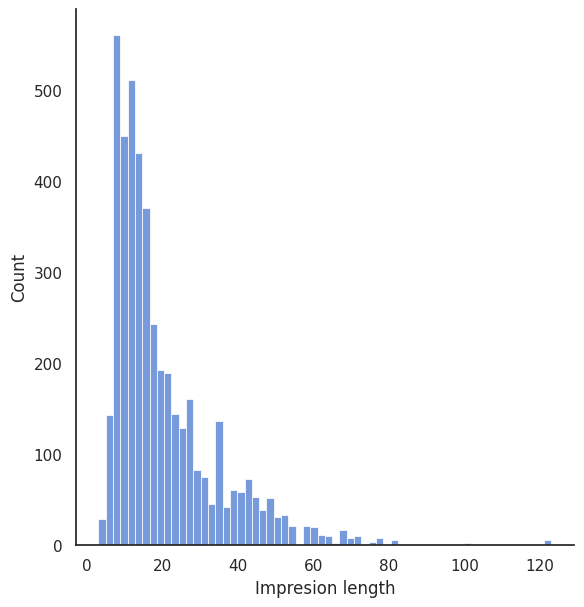


Value Counts for caption length top 5 values

Length|Counts
7     298
12    275
8     263
11    237
9     230
dtype: int64

The max and min value of "caption length" was found to be 123 and 3 respectively
The 80 percentile value of caption_len which is 29 will be taken as the maximum padded value for each impression


In [ ]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index[''] #tokened value of 
end_index = tokenizer.word_index[''] #tokened value of 


#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader